In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('tiny-shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


To make inputs out of this big string of data, we will be splitting it into chunks.

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ULINA:
What, sovereign sir,
I did not well I meant well. All my services
You have paid home: but that you have vouchsafed,
With your crown'd brother and these your contracted
Heirs of your kingdoms, my


In [3]:
chunk_lenchunk_l  = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [5]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [6]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [7]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [8]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [9]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

# Shakespeare

 43s (100 5%) 2.1883]
Whorriver,
Toud favheres tath ar cap lige ace out chearst, and sin willled randw'll unait leagives ati 

 15s (200 10%) 2.2672]
Whall of your iter seall denean, hee thouss heers and sould heat tager! od I mais of lempe hell to in  

 45s (300 15%) 1.9933]
Wher kengntrain the so her unders to a will to kame rusish of the live?

Nulingsh the me hise vith as  

 11s (400 20%) 2.1268]
Whem thou th I musts, it that wither, the good upe the clase offeis thy, fith as sor:
And wom:
This th 

 38s (500 25%) 1.8048]
What deuts wath than than quelited.
Who way't woinges sworbed too ken fo we dow with my sald did morse 

 6s (600 30%) 1.9866]
Wher, peak for to make would a wen'd aginst mesmesmand me as the, thou fail, we inith
this mponsteive  

 32s (700 35%) 1.8252]
Wh your heeced in this bleatigh our Monguion,
The cown beather brint, held mant of lied the laidion,
T 

 1s (800 40%) 1.7446]
When do satiour benarrow, you pold reentle fell;
And I there swe be thins for is the

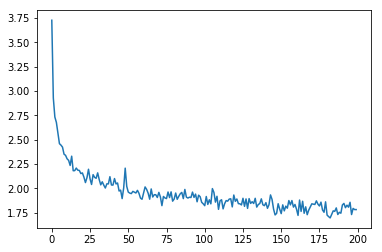

In [10]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [11]:
from string import ascii_uppercase
for c in ascii_uppercase:
    print(evaluate(c, 200), '\n')
    print('--------------------------------------')

Awn:
But silt boten; and tries the is be to sold mone tely solived
That your may the hath the will son agteeve, thine know me, and that the some thoush of imastry,
And thoughter that wh the preat thy b 

--------------------------------------
By so mings toron with undimerporst my havens!
And shuld this come, and and thus wherears a thants, to at his tage the or trught--
meet two dreand somesed his to nave if kirs,
And so commitorench bell. 

--------------------------------------
CHOR:
And brome the lords, and more vise the take to have's natue heavenal:
And le, and and a ching'd take a que him dall reat
To thou sregates thee.

LADY VONTERA:
Mechery it these in that I well will 

--------------------------------------
DAMAN:
Nurys to sir.

BIANCENIO:
In a that what that age of that I have thy same too.

PRAM:
Dineto, remandor but and, what's two the take the temprongon request enate; and my rerighmproyer 'arm.

BAPT 

--------------------------------------
END IIW:
For this toberr to 

# HPMOR

 33s (100 5%) 2.1986]
Whof hage have worsing
thidngher uruke rey theidg wading to ide o beller ha co. Harry wicinghat illard 

 59s (200 10%) 2.0469]
Whary sat Po the thave linges, sapoo
wast tren't M fich the doele mumed, and ho turntike het sre to an 

 25s (300 15%) 2.1099]
Wharl 2ell gortins. "In dumble carding the cood that eare turt woht
orce for the that had nolise eaisc 

 53s (400 20%) 1.8864]
When tyou gant is thaviing alloe perfiond was ender. "or."

Therdest ning that kner. "I didestien.

Pr 

 19s (500 25%) 1.8888]
Wh....

Harry and to le wars bother thous wither
heard Chat and heard realing were a puching.

"I'm as 

 45s (600 30%) 1.7194]
n the wide for flilund And the said this he's that the been on yeret conding bef exy on
Gering frav 

 13s (700 35%) 1.9023]
Whered and Mirment they nall a MuGand a be becayts
forfy
cellice falled and
would and that a forneck-s 

 38s (800 40%) 1.9022]
Wh nowmy the my of there when Aurgering
manst
buct the seid. "Eekin the was allong th

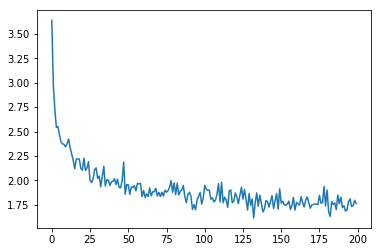

In [12]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
file = unidecode.unidecode(open('HPMOR.txt').read())

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [13]:
from string import ascii_uppercase
for c in ascii_uppercase:
    print(evaluate(c, 200), '\n')
    print('--------------------------------------')

AN So I do, to goon out find to that said Professor Spirsts. But you up All Arons. Hemorused the iknown his louse I can feeling temporirgut that hernestuended. And that arn of 6waks like a feel. "Why.
 

--------------------------------------
Boy," somewhere, faible. "Whe
ithem. Harry of there was giving one of diding
and posical by solised, and and they. Than the elming thought with right whieding to know
to a lake And the Siness, nampes.  

--------------------------------------
CRA Sastaning plotch," Class from enought down and they poor. Harry hadn't the gran the out seen at the boling it wear as the was. DrONGb
whange.

And pereficcel of 6ucked and
his here herner of aidn't 

--------------------------------------
DEMS" Potter persain.

Heniture you prite," "I chippered thang, when thest same. "You piress..."

"He whyer poicoss to to and you.

"You is me had getsen
his
be ide, I get as Muggly voice 6," 
The gape 

--------------------------------------
E Go there on the buschers?"